In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader


# Load the data and create a DataFrame
D = np.load('../data/Lorenz_data.npy')
df = pd.DataFrame(D)
df.columns = ["time", "x", "y","z"]  
df

,time,x,y,z
0,0.000000,-11.783618,3.527359,12.356182
1,0.008008,-10.662556,2.077418,11.846309
2,0.016016,-9.735181,0.733408,11.482696
3,0.024024,-8.978741,-0.513167,11.232045
4,0.032032,-8.373017,-1.673767,11.069919
...,...,...,...,...
995,7.967968,11.734805,10.459749,32.546310
996,7.975976,11.616529,9.940428,32.802521
997,7.983984,11.466892,9.409619,32.994403
998,7.991992,11.287723,8.875007,33.121536


In [3]:
# Extract x, y, and z time series
timeseries_x = df[["x"]].values.astype('float32')
timeseries_y = df[["y"]].values.astype('float32')
timeseries_z = df[["z"]].values.astype('float32')

# train-test split for time series
train_size = int(len(timeseries_x) * 0.85)
test_size = len(timeseries_x) - train_size

# Extract time series for overall data
times = df[["time"]].values.astype('float32')
timeseries =  df[["x", "y","z"]]


# train-test split for x, y, and z time series
x_train, x_test = timeseries_x[:train_size], timeseries_x[train_size:]
y_train, y_test = timeseries_y[:train_size], timeseries_y[train_size:]
z_train, z_test = timeseries_z[:train_size], timeseries_z[train_size:]
t_train, t_test = times[:train_size], times[train_size:]



In [4]:

# Function to create the dataset
def create_dataset(dataset_x, dataset_y, dataset_z, lookback):
    X, y = [], []
    for i in range(len(dataset_x)-lookback):
        # Create feature by stacking lookback points of x, y, and z
        feature = np.column_stack((dataset_x[i:i+lookback], dataset_y[i:i+lookback], dataset_z[i:i+lookback]))
        # Create target by stacking lookback+1 points of x, y, and z
        target = np.column_stack((dataset_x[i+1:i+lookback+1], dataset_y[i+1:i+lookback+1], dataset_z[i+1:i+lookback+1]))  
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 5
X_train, y_train  = create_dataset(x_train, y_train, z_train, lookback=lookback)


/tmp/ipykernel_22140/2105273194.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor(X), torch.tensor(y)


In [6]:

class RNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=3, hidden_size=100, num_layers=1, batch_first=True)
        self.linear = nn.Linear(100, 3)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x


In [54]:

# Learning rate and scheduler
lr = 0.01
factor = 0.995
patience = 250

history_RNN = []
model = RNNModel()
optimizer = optim.Adam(model.parameters(),lr=lr)
loss_fn = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode=  'min', factor=factor, patience=patience)

loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 5000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        history_RNN.append([loss.item(), optimizer.param_groups[0]['lr']])
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = loss_fn(y_pred, y_train)

    print("Epoch %d: train MSE %.4e, lr %.4e" % (epoch, train_rmse,optimizer.param_groups[0]['lr']))


torch.save(model.state_dict(), '../models/Lorenz_LSTM.pt')

Epoch 0: train MSE 7.3412e+00, lr 1.0000e-02
Epoch 100: train MSE 4.1760e-02, lr 8.4331e-03
Epoch 200: train MSE 4.5006e-02, lr 6.9356e-03
Epoch 300: train MSE 1.4037e-02, lr 5.6472e-03
Epoch 400: train MSE 1.2970e-02, lr 4.6212e-03
Epoch 500: train MSE 3.9816e-03, lr 3.7627e-03
Epoch 600: train MSE 7.9136e-03, lr 3.0791e-03
Epoch 700: train MSE 2.3862e-03, lr 2.5197e-03
Epoch 800: train MSE 2.2578e-03, lr 2.0516e-03
Epoch 900: train MSE 1.0562e-03, lr 1.6621e-03
Epoch 1000: train MSE 7.7279e-04, lr 1.3533e-03
Epoch 1100: train MSE 4.6614e-04, lr 1.1075e-03
Epoch 1200: train MSE 4.7215e-04, lr 9.0627e-04
Epoch 1300: train MSE 3.9817e-04, lr 7.3791e-04
Epoch 1400: train MSE 6.7137e-04, lr 5.9483e-04
Epoch 1500: train MSE 3.6473e-04, lr 4.8433e-04
Epoch 1600: train MSE 1.9187e-04, lr 3.9435e-04
Epoch 1700: train MSE 2.2374e-04, lr 3.1949e-04
Epoch 1800: train MSE 1.4926e-04, lr 2.6014e-04
Epoch 1900: train MSE 1.6410e-04, lr 2.1075e-04
Epoch 2000: train MSE 1.4311e-04, lr 1.7074e-04
Epoc

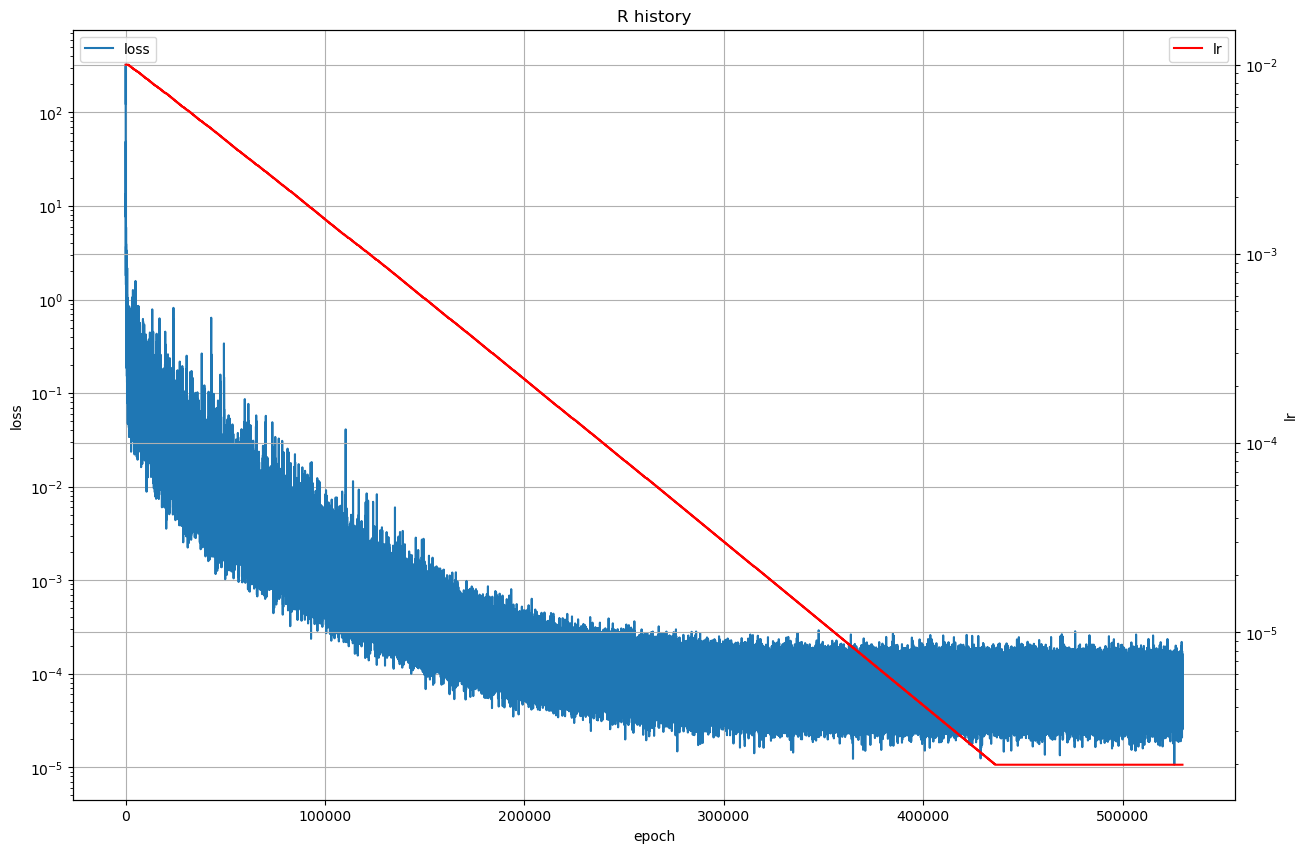

In [55]:
# plot history_FFNN loss and lr in two subplots
history = np.array(history_RNN)

fig, ax = plt.subplots(figsize=(15, 10))
# plot the loss
ax.plot(history[:, 0], label='loss')
ax.legend(loc='upper left')
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.grid()

# plot the learning rate
ax2 = ax.twinx()
ax2.plot(history[:, 1], label='lr', color='r')
ax2.set_yscale('log')
ax2.set_ylabel('lr')
# legend to the right
ax2.legend(loc='upper right')
plt.grid()
plt.title('R history')

# save the figure
plt.savefig('../plot/Lorenz_RNN_history.png')

In [7]:

model = RNNModel()
model.load_state_dict(torch.load('../models/Lorenz_LSTM.pt'))
model.eval()

# Initialize an empty plot for position, velocity, and time
train_plot_x = np.ones_like(timeseries_x) * np.nan
train_plot_y = np.ones_like(timeseries_y) * np.nan
train_plot_z = np.ones_like(timeseries_z) * np.nan
test_plot_x = np.ones_like(timeseries_x) * np.nan
test_plot_y = np.ones_like(timeseries_y) * np.nan
test_plot_z = np.ones_like(timeseries_z) * np.nan

with torch.no_grad():
    # Generate the model predictions for training and testing data
    train_last_x = model(X_train)[:, -1, 0].numpy()
    train_last_y = model(X_train)[:, -1, 1].numpy()
    train_last_z = model(X_train)[:, -1, 2].numpy()
    train_plot_x[lookback:lookback + len(train_last_x)] = train_last_x.reshape(-1, 1)
    train_plot_y[lookback:lookback + len(train_last_y)] = train_last_y.reshape(-1, 1)
    train_plot_z[lookback:lookback + len(train_last_z)] = train_last_z.reshape(-1, 1)

    input_seq_x = torch.from_numpy(train_last_x[-lookback:])
    input_seq_y = torch.from_numpy(train_last_y[-lookback:])
    input_seq_z = torch.from_numpy(train_last_z[-lookback:])
    input_seq = torch.stack([input_seq_x, input_seq_y, input_seq_z], dim=1)
    input_seq = input_seq.view(1, lookback, 3)
    x_test, y_test, z_test = [], [], [] 
    for i in range(len(timeseries_x) - (train_size + lookback)):
        predicted = model(input_seq)
        x_test.append(predicted[:, -1, 0].item())
        y_test.append(predicted[:, -1, 1].item())
        z_test.append(predicted[:, -1, 2].item())
        new_line = predicted[:, -1, :].unsqueeze(0)
        input_seq = torch.cat([input_seq, new_line], dim=1)
        input_seq = input_seq[:, 1:, :]

    test_last_x = np.array(x_test)
    test_last_y = np.array(y_test)
    test_last_z = np.array(z_test)
    test_plot_x[train_size:len(timeseries_x)-lookback] = test_last_x.reshape(-1, 1)
    test_plot_y[train_size:len(timeseries_y)-lookback] = test_last_y.reshape(-1, 1)
    test_plot_z[train_size:len(timeseries_z)-lookback] = test_last_z.reshape(-1, 1)
    


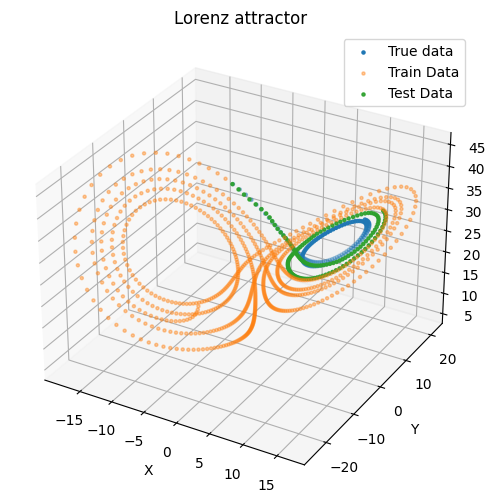

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

test_true_x = timeseries_x[train_size:len(timeseries_x)-lookback]
test_true_y = timeseries_y[train_size:len(timeseries_x)-lookback]
test_true_z = timeseries_z[train_size:len(timeseries_x)-lookback]


# Create a 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the training data
ax.scatter(test_true_x,test_true_y,test_true_z,marker='.',label = 'True data')
ax.scatter(train_plot_x, train_plot_y, train_plot_z,marker = '.',  label='Train Data',alpha = 0.4)

# Plot the testing data
ax.scatter(test_plot_x, test_plot_y, test_plot_z,marker = '.',  label='Test Data',alpha=0.9)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz attractor')

# Add a legend
ax.legend()

plt.savefig('../plot/Lorenz_RNN.pdf')
# Show the plot
plt.show()


In [10]:
from sklearn.metrics import mean_squared_error

# Remove nan values from the arrays
clean_test_true_x = test_true_x[~np.isnan(test_true_x)]
clean_test_true_y = test_true_y[~np.isnan(test_true_y)]
clean_test_true_z = test_true_z[~np.isnan(test_true_z)]
clean_test_pred_x = test_plot_x[~np.isnan(test_plot_x)]
clean_test_pred_y = test_plot_y[~np.isnan(test_plot_y)]
clean_test_pred_z = test_plot_z[~np.isnan(test_plot_z)]

#clean_test_true_x = clean_test_true_x [:np.int64(len(clean_test_true_x)*0.25)]
#clean_test_true_y = clean_test_true_y [:np.int64(len(clean_test_true_y)*0.25)]
#clean_test_true_z = clean_test_true_z [:np.int64(len(clean_test_true_z)*0.25)]
#clean_test_pred_x = clean_test_pred_x [:np.int64(len(clean_test_pred_x)*0.25)]
#clean_test_pred_y = clean_test_pred_y [:np.int64(len(clean_test_pred_y)*0.25)]
#clean_test_pred_z = clean_test_pred_z [:np.int64(len(clean_test_pred_z)*0.25)]

# Calculate RMSE for x, y, z coordinates
mse_x = mean_squared_error(clean_test_true_x, clean_test_pred_x)
mse_y = mean_squared_error(clean_test_true_y, clean_test_pred_y)
mse_z = mean_squared_error(clean_test_true_z, clean_test_pred_z)

loss_RNN = (mse_x + mse_y + mse_z) 

print("mse: ",loss_RNN)


mse:  0.4464128
